In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental faiss-cpu tiktoken pypdf langchain openai langchain_anthropic langchain_experimental


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langgraph.graph import START, END, StateGraph
from langchain.chains import ConversationalRetrievalChain
from langchain_core.tools import tool
from typing_extensions import TypedDict
from dotenv import load_dotenv, find_dotenv
import tiktoken
from IPython.display import Image, display
import random


In [43]:
# Carga de variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

In [44]:
# Cargar el PDF
loader = PyPDFLoader("embeddings/manual_rrhh.pdf")
docs = loader.load()

# Fragmentar el texto
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

# Crear embeddings e índice
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)
vectorstore.save_local("embeddings/faiss_index")

In [45]:
class PDFQuestionState(TypedDict):
    question: str
    docs: list

@tool
def retrieve_from_pdf(question: str) -> dict:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    vectorstore = FAISS.load_local(
        "embeddings/faiss_index",
        OpenAIEmbeddings(),
        allow_dangerous_deserialization=True
    )
    retriever = vectorstore.as_retriever()
    docs = retriever.invoke(question)
    return {"question": question, "docs": docs}



In [50]:
@tool
def answer_question(question: str, docs: list) -> dict:
    """
    Usa un LLM para responder la pregunta del usuario basada en documentos recuperados.
    """
    llm = ChatOpenAI(temperature=0)
    chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=FAISS.load_local(
            "embeddings/faiss_index",
            OpenAIEmbeddings(),
            allow_dangerous_deserialization=True
        ).as_retriever()
    )
    response = chain.invoke({"question": question, "chat_history": []})
    return {"question": question, "docs": docs, "answer": response["answer"]}


In [51]:
OTP_CODE = "123456"
@tool
def otp_verification(user_id: str, otp_input: str = "") -> dict:
    """
    Verifica un código OTP para el usuario.
    """
    if otp_input == "":
        print(f"🔐 Enviando código OTP a usuario {user_id}...")
        print(f"(Para pruebas, el código es: {OTP_CODE})")
        return {
            "user_id": user_id,
            "awaiting_otp": True,
            "otp_valid": False,
            "otp_input": ""
        }

    if otp_input == OTP_CODE:
        print("✅ Código OTP validado.")
        return {
            "user_id": user_id,
            "otp_valid": True,
            "awaiting_otp": False,
            "otp_input": otp_input
        }

    print("❌ Código OTP incorrecto.")
    return {
        "user_id": user_id,
        "otp_valid": False,
        "awaiting_otp": False,
        "otp_input": otp_input
    }




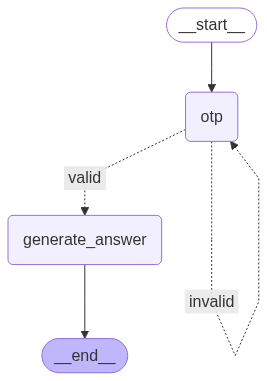

In [55]:
class GraphState(TypedDict, total=False):
    user_id: str
    otp_input: str
    otp_valid: bool
    awaiting_otp: bool
    question: str
    docs: list
    answer: str



graph = StateGraph(GraphState)

graph.add_node("otp", otp_verification)
graph.add_node("generate_answer", answer_question)  # ejemplo de nodo protegido

# Entrada → OTP → si válido → nodo protegido
graph.set_entry_point("otp")

graph.add_conditional_edges(
    "otp",
    lambda state: (
        "awaiting_otp" if state.get("awaiting_otp") else
        "valid" if state.get("otp_valid") else
        "invalid"
    ),
    {
        "awaiting_otp": "otp",
        "valid": "generate_answer",
        "invalid": "otp"
    }
)


graph.set_finish_point("generate_answer")
faq_graph = graph.compile()

display(Image(faq_graph.get_graph().draw_mermaid_png()))


In [26]:
result = faq_graph.invoke({"question": "¿Cuántos días de vacaciones me corresponden?"})
print(result["answer"])

Según el Manual de RRHH de ICPACIFICO, a todo trabajador le corresponden 15 días hábiles de vacaciones por cada año trabajado.


In [56]:
# 1. Enviar OTP
step1 = faq_graph.invoke({"user_id": "usuario123", "otp_input": ""})

# 2. Enviar el código (debe incluir el mismo `user_id`)
step2 = faq_graph.invoke({
    "user_id": "usuario123",
    "otp_input": "123456",
    **{k: v for k, v in step1.items() if k not in ["otp_input"]}  # preserva estado
})

print("✅ Resultado:")
print(step2.get("answer", step2))


🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 Enviando código OTP a usuario usuario123...
(Para pruebas, el código es: 123456)
🔐 En

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT